# Project 1 - code 
It is all meant to be run in order

## A whole heap of setup

### Imports
These appear to be the standard imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from imageio import imread

### The Franke Function

We define the Franke Function, and do it plot of it.
All of that is from the project description. 

The only non-standard thing we do, is define a function Franke_on_row, 
which is just a wrapper to apply the Franke Function to a list with two elements.  

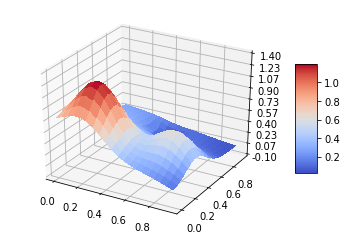

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
fx = np.arange(0, 1, 0.05)
fy = np.arange(0, 1, 0.05)
fx, fy = np.meshgrid(fx,fy)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# A wrapper to let us apply FrankeFunction to a list of the form row = [x, y]
def Franke_on_row(row):
    return FrankeFunction(row[0], row[1])

fz = FrankeFunction(fx, fy)

# Plot the surface.
surf = ax.plot_surface(fx, fy, fz, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Regression methods
We define the classes polynomialOLS, polynomialRidge, and polynomialLasso. 
Each will take a degree, and the later two also a parameter lamb.
They each implement train and predict functions.
The idea is that one initiates a polynomial method pm with a given degree, 
then we can simply pass a two-column matrix XY with x and y values to train and predict,
the classes themselves will then call polymatrix to get a matrix with all the terms needed 
to get a polynomial of the given degree. 
The Ridge regression class also takes care to center the input. 
That is all just to make calling the functions easier. 

Each class also has plotfunc, coefficients and info methods. 

The plotfunc is simply a wrapper used to predict on a single pair of points (x,y). 
I use it because I had problems with applying predict when plotting. 

The coefficients methods returns a column vector consisting of the beta functions. 

The info method does some printing we use later to make nice output. 

In [3]:
# We are only going to work with input in two dimensions
# and output in one.
# Hence all our code will be writting with this assumption 

# Given a matrix XY with two columns x,y return an array with columns x, y, x^2, xy, y^2, ... y^n 
def polymatrix(XY, n):
    X = XY[:,[0]]
    Y = XY[:,[1]]
    ones = np.ones((len(X), 1))
    pl = np.concatenate([(np.power(X,k-i)*np.power(Y,i)) for k in range(1, n+1) for i in range(0,k+1)], axis=1)
    return np.hstack((ones, pl))


# This is a class for doing the most basic OLS regression 
class myOLS :
    
    # We have one class virable beta which has the coefficients for the linear regression
    def __init__(self):
        self.beta = 0
    
    # This method sets beta on the given training matrix xb with know values y.
    def train(self, xb, y):
        self.beta = np.linalg.inv(xb.T.dot(xb)).dot(xb.T).dot(y)

    # Use our beta to predict on a (correctly formatted) matrix xb.
    def predict(self, xb):
        return xb.dot(self.beta)
    
# This class is simply a wrapper for the myOLS class
# It simply takes care of transforming the raw input into proper polynomial input
class polynomialOLS :
    
    def __init__(self, n):
        self.polyOLS = myOLS()
        self.degree = n
    
    # Train our polynomial OLS.
    # We take matrix XY with two columns x,y and given zs as output. 
    # First we use polymatrix to transform XY to matrix with rows 1, x, y, x^2, xy, y^2 ...
    # Then we feed that as the training data to an ordinary OLS
    def train(self, XY, z):
        xb = polymatrix(XY, self.degree)
        self.polyOLS.train(xb,z)

    # Predict our polynomial solution 
    # As in train we take a matrix XY with two columns x,y.  
    # First we use polymatrix to transform XY to matrix with rows 1, x, y, x^2, xy, y^2 ...
    # Then use that as input to predict on an ordinart OLS
    def predict(self, XY):
        xb = polymatrix(XY, self.degree)
        return self.polyOLS.predict(xb)
    
    # This is only used for plotting. 
    # It is just a wrapper function to predict the value a single (x,y) pair
    # Given two numbers x,y it just applies predict to an array with x and y as columns
    def plotfunc(self, x, y):
        return self.predict(np.array([[x, y]]))
     
    # Prints the coefficients beta
    def coefficients(self):
        return self.polyOLS.beta

    # A function to print some pretty information about this regression model  
    def info(self):
        print("OLS regression, trying to fit a polynomial of degree %d " % self.degree)

class polynomialRidge : 
    
    def __init__(self, n, lamb):
        self.degree = n
        self.lamb = lamb
        self.beta = 0
        self.intercept = 0
    
    # takes a column or row vecter x, and returns x - bar{x},
    # where bar{x} is the avarage of the entries in x
    # Also works on any size matrix, but that is not what we have in mind
    def center(self, x) :
        return x - np.mean(x)
    
    # Train our polynomial ridge regression.
    # We take matrix XY with two columns x,y and given zs as output. 
    # First we transform XY to matrix with columns x, y, x^2, xy, y^2 ...
    # Then we center each row.
    # Finally wecompute beta according to formula from Hastings (3.44) 
    def train(self, XY, z):
        xb = polymatrix(XY, self.degree) 
        xb = np.delete(xb, 0, 1) # removes the column of 1s 
        xb_centered = np.apply_along_axis(self.center, 0, xb) # center each column
        xbrows = len(xb[0,:]) # number of rows in xb
        b0 = self.center(z)
        self.beta = (np.linalg.inv(xb_centered.T.dot(xb_centered) + self.lamb*np.identity(xbrows)).dot(xb_centered.T)).dot(b0)
        self.intercept = np.mean(z) - (np.mean(xb, axis = 0)).dot(self.beta) 
        
    # Predict our polynomial solution 
    # As in train we take a matrix XY with two columns x,y.  
    # First we transform XY to matrix with columns x, y, x^2, xy, y^2 ...
    # Then use beta and intecept to predict the value
    def predict(self, XY):
        xb = polymatrix(XY, self.degree) 
        xb = np.delete(xb, 0, 1) # removes the column of 1s
        return xb.dot(self.beta) + self.intercept
    
    # This is only used for plotting. 
    # It is just a wrapper function to predict the value a single (x,y) pair
    # Given two numbers x,y it just applies predict to an array with x and y as columns
    def plotfunc(self, x, y):
        return self.predict(np.array([[x, y]]))
     
    # Returns the coefficients beta (a long with intercept) as a column vector
    # vstack puts the intercept ontop of the other betas
    def coefficients(self):
        return np.vstack(([self.intercept], self.beta))
    
    # A function to print some pretty information about this regression model  
    def info(self):
        print("Ridge regression, trying to fit a polynomial of degree %d " % self.degree)
        print("Lambda = %.4f" % self.lamb)
    
class polynomialLasso :
    
    def __init__(self, n, lamb):
        self.lasso = Lasso(alpha = lamb)
        self.degree = n
        self.lamb = lamb
        
    # Train our polynomial lasso.
    # We take matrix XY with two columns x,y and given zs as output. 
    # First we transform XY to matrix with columns x, y, x^2, xy, y^2 ...
    # Then we center each row.
    # Finally wecompute beta according to formula from Hastings (3.44) 
    def train(self, XY, z):
        xb = polymatrix(XY, self.degree) 
        xb = np.delete(xb, 0, 1) # removes the column of 1s 
        self.lasso.fit(xb, z)
        
    # Predict our polynomial solution 
    # As in train we take a matrix XY with two columns x,y.  
    # First we transform XY to matrix with columns x, y, x^2, xy, y^2 ...
    # Then use beta and intecept to predict the value
    def predict(self, XY):
        xb = polymatrix(XY, self.degree) 
        xb = np.delete(xb, 0, 1) # removes the column of 1s
        return np.c_[self.lasso.predict(xb)]
    
    # This is only used for plotting. 
    # It is just a wrapper function to predict the value a single (x,y) pair
    # Given two numbers x,y it just applies predict to an array with x and y as columns
    def plotfunc(self, x, y):
        return self.predict(np.array([[x, y]]))
     
    # Returns the coefficients (including intercept) as a column vector
    # reshape(-1,1) makes the array of coef_ into a column vector
    # we put intercept_ on top of it.
    def coefficients(self):
        # resha
        return np.vstack((self.lasso.intercept_, self.lasso.coef_.reshape(-1,1)))

    def info(self):
        print("Lasso regression, trying to fit a polynomial of degree %d " % self.degree)
        print("Lambda = %.4f" % self.lamb)

### Test of regression functions

We verify that the classes we build yield the same outcome as the build-in functions of sci-kit learn. 

In [4]:
print("Test of regression methods and polymatrix")
print("-------------------")
print("")
print("Testing polymatrix. Making first a random (4,2) array")
test_XY = np.random.rand(100,2)
test_z = np.c_[np.apply_along_axis(Franke_on_row, 1, test_XY)]
#print(test_XY)
print("")

for test_degree in range(1,6) :
    print("For degree %d the mean diffrence between polymatrix and PolynomialFeatures are" % test_degree)
    poly = PolynomialFeatures(test_degree)
    print(np.mean(polymatrix(test_XY, test_degree) - poly.fit_transform(test_XY)))
    print("")
    
print("-------------------")
print("")
print("Testing how my ols and ridge methods differ from the sci-kit learn ones")
print("")
for test_degree in range(1,6) :
    
    print("We look at a polynomial of degree %d" % test_degree)
    poly = PolynomialFeatures(test_degree)
    poly_XY = poly.fit_transform(test_XY)
    # We remove the leading column of 1s
    # This is done since we call teh fit functions without setting fit_intercept to false
    # So in essence, the fit of OLS and more importantly Ridge makes sure to find the intercept on its own
    poly_XY = np.delete(poly_XY, 0, 1) 
    
    
    # Setup "my" OLS regression
    myols = polynomialOLS(test_degree)
    myols.train(test_XY, test_z)
    # Setup sci-kit learns OLS regression
    scikit_ols = LinearRegression()
    scikit_ols.fit(poly_XY, test_z)
    # make a column vector of betas for scikit_ols
    skols_betas = np.vstack((scikit_ols.intercept_, scikit_ols.coef_.reshape(-1,1)))
    print("Mean difference of hand computed intercept and coefs for OLS")
    print(np.mean(myols.coefficients() - skols_betas))
    
    # Setup "my" ridge regression 
    myridge = polynomialRidge(test_degree, 0.5)
    myridge.train(test_XY, test_z)
    # Setup sci-kit learns ridge regression
    scikit_ridge = Ridge(alpha = 0.5)
    scikit_ridge.fit(poly_XY, test_z)
    skridge_betas = np.vstack((scikit_ridge.intercept_, scikit_ridge.coef_.reshape(-1,1)))
    print("Mean difference of hand computed intercept and coefs for Ridge")
    print(np.mean(myridge.coefficients() - skridge_betas))
    


Test of regression methods and polymatrix
-------------------

Testing polymatrix. Making first a random (4,2) array

For degree 1 the mean diffrence between polymatrix and PolynomialFeatures are
0.0

For degree 2 the mean diffrence between polymatrix and PolynomialFeatures are
0.0

For degree 3 the mean diffrence between polymatrix and PolynomialFeatures are
2.524344530066211e-19

For degree 4 the mean diffrence between polymatrix and PolynomialFeatures are
3.493005673427315e-19

For degree 5 the mean diffrence between polymatrix and PolynomialFeatures are
2.3215042611641024e-19

-------------------

Testing how my ols and ridge methods differ from the sci-kit learn ones

We look at a polynomial of degree 1
Mean difference of hand computed intercept and coefs for OLS
5.181040781584064e-16
Mean difference of hand computed intercept and coefs for Ridge
3.700743415417188e-17
We look at a polynomial of degree 2
Mean difference of hand computed intercept and coefs for OLS
-5.78241158658935

### Cross validation

In [5]:
# This function does k-fold cross validation 
# It takes a k, a matrix XY with two columns of inputs, and corresponding true values z (all of appropirate sizes)
# It also takes a model which we assume have train, predict, and coefficients functions.
# Both should work on these matrices 
# We return the expected error, and a list of computed coefficients for our model
def cross_validation(k, XY, z, model):
    
    sqdiffs = []
    clength = len(XY[:,0]) # the length of the first column in XY
    permutation = np.random.permutation(clength) # a permutation of the indexes of rows in XY
    partitions = np.array_split(permutation, k) # The permutation is devided in to k almost equally big groups
    
    for i in range(0,k) :
        # create a mask to pick everything but the elements in the i'th partition
        mask = np.ones(clength,dtype=bool)
        mask[partitions[i]] = 0
        # now train on everything but the i'th partition
        model.train(XY[mask, :], z[mask, :])
        # make the mask the picks only the elements of the i'th partition
        notmask = np.invert(mask)
        # update the sqdiffs of predicted values and the true values in the i'th partition  
        zpredict = model.predict(XY[notmask, :])
        sqdiffs.append(np.power(zpredict - z[notmask, :],2))
    
    pred_mse = np.mean(sqdiffs)
    return pred_mse   

### Statitistics functions

Just a small collection of statistics functions we will use to evaluate the preformance of our models

In [6]:
def MSE(x, y):
    return np.mean(np.power(x-y, 2))

def r2d2score(ytrue, ypredict):
    truemean = np.mean(ytrue)
    return 1 - (np.sum(np.power(ytrue-ypredict, 2))/np.sum(np.power(ytrue-truemean, 2)))

# variance of a column of row vector x
def variance(x):
    return np.mean(np.power(x - np.mean(x), 2))

# Given input data XY, z, and a model.
# We first train the model on XY, z.
# Then we compute the MSE and R2 score of the prediction vs the true values
# After thinking it over, this just seems boring, so it wont be used 
def basic_tests(XY, z, model) :
    model.train(XY, z)
    zpredict = model.predict(XY)
    mse = MSE(z, zpredict)
    r2 = r2d2score(z, zpredict)
    model.info()
    print("MSE = %.4f" % mse)
    print("R2 scrore = %.4f" %r2)
    print("----------------")

    
    
# Given a model already trained on some data, and some new data XY, z 
# Compute MSE and R2 scores of the models prediction of the newdata against it true new zs
def test_against_new(newXY, newz, model):
    zpredict = model.predict(newXY)
    mse = MSE(newz, zpredict)
    r2 = r2d2score(newz, zpredict)
    model.info()
    print("MSE = %f" % mse)
    print("R2 scrore = %f" % r2)
    print("----------------")

### Statistics functions test

In [7]:
print("Testing the basic statistics functions")
print("")
# make two lists of random numbers
# we need the ravel or the build in r2_score behaves in an odd way
xs = np.random.rand(1,100).ravel()
ys = np.random.rand(1,100).ravel()
mse_diff = MSE(xs,ys) - mean_squared_error(xs,ys)
print("MSE difference between mine and sci-kit learns: %f " % mse_diff)
r2_diff = r2d2score(xs,ys) - r2_score(xs,ys)
print("R2 difference between mine and sci-kit learns: %f " % r2_diff)

Testing the basic statistics functions

MSE difference between mine and sci-kit learns: 0.000000 
R2 difference between mine and sci-kit learns: 0.000000 


### BV estimate and confidence intervals
Functions to estimate the bias and variance and confidence intervals of a given model.
They are just minor modifications of the confidence interval code, and really one should probably do both (or all 3) in one go.


In [8]:
# This function tries to estimate the variance and bias of our model  
# It takes a k, a matrix XY with two columns of inputs, and corresponding true values z (all of appropirate sizes)
# It also takes a model which we assume have train, predict, and coefficients functions.
# We return the variance and bias of computing the model on k subsets of XY
# when compared to a single "true" set
def BV_estimate(k, XY, z, model):
    
    clength = len(XY[:,0]) # the length of the first column in XY
    permutation = np.random.permutation(clength) # a permutation of the indexes of rows in XY
    partitions = np.array_split(permutation, k+1) # The permutation is devided in to k+1 almost equally big groups
    preds_list = [] # this will be a list of the predicted out comes
    
    # create a mask to pick everything in the k'th partition
    # this is the partition we will compare aginst
    fixed_mask = np.zeros(clength,dtype=bool)
    fixed_mask[partitions[k]] = 1
       
    for i in range(0,k) :
        # create a mask to pick everything but the i'th partition
        mask = np.ones(clength,dtype=bool)
        mask[partitions[i]] = 0
        mask[partitions[k]] = 0
        # now train on the i'th partition
        model.train(XY[mask, :], z[mask, :])
        # now predict what will happen on the fixed set
        zpredict = model.predict(XY[fixed_mask, :])
        preds_list.append(zpredict)
    
    # transform from list of column vectors to a single matrix
    # each row contains the prediction of a single xy point
    preds_matrix = np.hstack(preds_list)
    
    vari = np.mean(np.apply_along_axis(variance, 1, preds_matrix))
    bias = np.mean(np.power(np.mean(preds_matrix - z[fixed_mask, :], axis=1), 2))
    #mse = np.mean(np.power(preds_matrix - z[fixed_mask, :], 2))
    
    return bias, vari

##usage example:
#pRidge = polynomialOLS(4)
#print("Using 9 folds to predict variance and bias for a polynomial of degree %i." % 2)
#print(BV_estimate(9, XY, z, pRidge))

# This function estimates the variance of the betas  
# It takes a k, a matrix XY with two columns of inputs, and corresponding true values z (all of appropirate sizes)
# It also takes a model which we assume have train, predict, and coefficients functions.
# We return the variance the the betas when computing the model on k subsets of XY
def beta_variance(k, XY, z, model):
    
    clength = len(XY[:,0]) # the length of the first column in XY
    permutation = np.random.permutation(clength) # a permutation of the indexes of rows in XY
    partitions = np.array_split(permutation, k) # The permutation is devided in to k almost equally big groups
    beta_list = [] # this will be a list of the betas for each training session
    
    for i in range(0,k) :
        # create a mask to pick everything but the elements in the i'th partition
        mask = np.ones(clength,dtype=bool)
        mask[partitions[i]] = 0
        # now train on everything but the i'th partition
        model.train(XY[mask, :], z[mask, :])
        beta_list.append(model.coefficients())
        
    # transform from list of column vectors to a single matrix
    # each row contains the "same beta" computed from different training session
    beta_matrix = np.hstack(beta_list)
    
    variances = np.apply_along_axis(variance, 1, beta_matrix)
    
    return variances

##usage example
#pRidge = polynomialOLS(4)
#print("Using 10 folds to compute variances of betas for a polynomial of degree %i." % 2)
#print(beta_variance(10, XY, z, pRidge))


## Acutally working with the models or solving parts a,b, c

### Data for all our test

In [53]:
# Setup input data. 
# We make numberofpoints points
# the x's and y's are chosen randomly 
# the z's according to the fomula and with some noise
number_of_points = 1000
noise = 0.2
XY = np.random.rand(number_of_points, 2) # a matrix of random numbers with 2 columns of length numberofpoints 

# we have to flip the normal dist array to get the right dimensions 
z = np.c_[np.apply_along_axis(Franke_on_row, 1, XY)] + np.c_[noise*np.random.normal(0,1,number_of_points)] 

# Now we make some "clean" data 
# Models will never be trained on this, only tested against it 
cleanXY = np.random.rand(100, 2) 
cleanz = np.c_[np.apply_along_axis(Franke_on_row, 1, cleanXY)] + np.c_[noise*np.random.normal(0,1,100)] 

### A, OLS

In [54]:
print("Testing OLS methods for polynomial of degrees 1,2,3,4, and 5.")
print("")
print("First we use 10 fold cross validation to decide which model is best.")
print("")

for n in range(1,6) :
    pOLS = polynomialOLS(n)
    pOLS.info()
    cv = cross_validation(10, XY, z, pOLS)
    print("The predicted error is %f" % cv)
    print("")

print("-------------")
print("")
print("Testing 5 degree polynomial model against new data")
    
# When I ran this to lowest predicted error came from the polynomial of degree 5
# so we will go with that model  

# We test the actual statistics against the unseen (clean) data
bestOLS = polynomialOLS(5)
bestOLS.train(XY, z)
print("The coefficients for our best OLS model is:")
print(bestOLS.coefficients())
test_against_new(cleanXY, cleanz, bestOLS)

# Now we compute the bias and variance of our model
# and esitamte the variance of the parameters beta

print("")
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, XY, z, bestOLS)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("Using 10 folds to compute variances of betas")
print(beta_variance(10, XY, z, bestOLS))

Testing OLS methods for polynomial of degrees 1,2,3,4, and 5.

First we use 10 fold cross validation to decide which model is best.

OLS regression, trying to fit a polynomial of degree 1 
The predicted error is 0.062884

OLS regression, trying to fit a polynomial of degree 2 
The predicted error is 0.058462

OLS regression, trying to fit a polynomial of degree 3 
The predicted error is 0.049181

OLS regression, trying to fit a polynomial of degree 4 
The predicted error is 0.046228

OLS regression, trying to fit a polynomial of degree 5 
The predicted error is 0.044361

-------------

Testing 5 degree polynomial model against new data
The coefficients for our best OLS model is:
[[  0.50487456]
 [  6.84139196]
 [  3.40447963]
 [-28.83003238]
 [-13.51823062]
 [ -8.49877932]
 [ 34.9506793 ]
 [ 36.27449647]
 [ 26.08048924]
 [ -9.02317215]
 [ -8.29829456]
 [-47.10130772]
 [ -3.18784026]
 [-41.11659721]
 [ 32.0059086 ]
 [ -5.18824459]
 [ 19.65607878]
 [  3.94561365]
 [ -1.70731701]
 [ 21.06

### A - a plot
We do a plot of our predicted model - franke function. 
If this had been a great model we should have seen a very flat plot, we don't quite

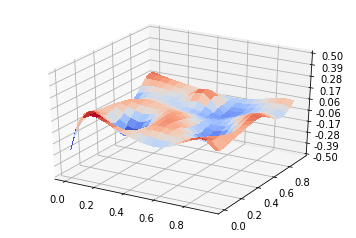

In [55]:
# retrain model as it has been modified by BV and variance computations
bestOLS.train(XY, z)

# Do a plot of the best model - franke
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make plot points .
xpoints = np.arange(0, 1, 0.05)
ypoints = np.arange(0, 1, 0.05)
xm, ym = np.meshgrid(xpoints,ypoints)

# Plot the real and predicted surfaces.
diffsurf = ax.plot_surface(xm, ym, np.vectorize(bestOLS.plotfunc)(xm,ym) - FrankeFunction(xm, ym), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.50, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(realsurf, shrink=0.5, aspect=5)

plt.show()

### B, ridge regression - model selection

In [56]:
print("Testing Ridge methods for polynomial of degrees 1,2,3,4, and 5.")
print("")
print("First we use 10 fold cross validation to decide which model is best.")
print("")

#Since printing out all the results of cross validation with different lambdas get tedious to read
# we make a list of cv values and corresponding degrees and lambdas. 
# Then we can just sort by the cv value to pick the best model
cv_list = []

for n in range(1,6) :
    for a in [0.1, 0.2, 0.5, 1] : 
        pRidge = polynomialRidge(n, a)
        cv = cross_validation(10, XY, z, pRidge)
        cv_list.append((n,a,cv))

cv_list.sort(key=lambda tup: tup[2]) #sort the list by the cv value

best_tup = cv_list[0]

print("The best model had a degree %d polynomial and a lambda of %f " % (best_tup[0], best_tup[1]))
print("It had a predicted error of %f" % best_tup[2])

# NOTE: Since this is not entirely deterministic, we some times get different answers.
# Mostly I get a degree 4 polynomial with a lambda of 0.1


Testing Ridge methods for polynomial of degrees 1,2,3,4, and 5.

First we use 10 fold cross validation to decide which model is best.

The best model had a degree 5 polynomial and a lambda of 0.100000 
It had a predicted error of 0.049839


### B - working with chosen model

In [57]:
# We will work with a degree 5 polynomial and a lambda of 0.1
# We test the actual statistics against the unseen (clean) data
bestRidge = polynomialRidge(5, 0.1)
bestRidge.train(XY, z)
print("The coefficients for our best Ridge model is:")
print(bestRidge.coefficients())
test_against_new(cleanXY, cleanz, bestRidge)

# Now we compute the bias and variance of our model
# and esitamte the variance of the parameters beta

print("")
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, XY, z, bestRidge)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("Using 10 folds to compute variances of betas")
print(beta_variance(10, XY, z, bestRidge))

The coefficients for our best Ridge model is:
[[ 1.06612447]
 [-0.43069641]
 [ 0.10905763]
 [-1.5575589 ]
 [ 0.99764565]
 [-2.0988343 ]
 [ 0.70765274]
 [ 0.73417389]
 [-0.66134346]
 [-0.28112356]
 [ 0.89019451]
 [ 0.6225893 ]
 [-0.21970549]
 [-0.32754434]
 [ 0.87460214]
 [-0.6857009 ]
 [-0.22535477]
 [-0.26390879]
 [-0.08609822]
 [ 0.23636058]
 [ 0.76602987]]
Ridge regression, trying to fit a polynomial of degree 5 
Lambda = 0.1000
MSE = 0.058986
R2 scrore = 0.539831
----------------

Using 9 folds to predict variance and bias
The bias is 0.054887
The variance is 0.000056

Using 10 folds to compute variances of betas
[0.00033641 0.00409355 0.00262426 0.00327892 0.00884094 0.00301148
 0.00212812 0.00403362 0.0044825  0.00108847 0.001235   0.00170429
 0.00141348 0.00185033 0.00048559 0.00107178 0.00369705 0.00535533
 0.00346365 0.00359964 0.00189097]


### B - the plot

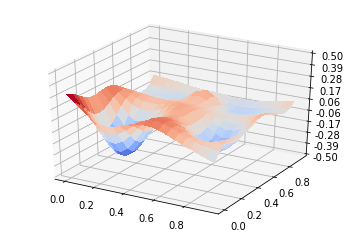

In [58]:
# retrain model as it has been modified by BV and variance computations
bestRidge.train(XY, z)

# Do a plot of the best model - franke
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make plot points .
xpoints = np.arange(0, 1, 0.05)
ypoints = np.arange(0, 1, 0.05)
xm, ym = np.meshgrid(xpoints,ypoints)

# Plot the real and predicted surfaces.
diffsurf = ax.plot_surface(xm, ym, np.vectorize(bestRidge.plotfunc)(xm,ym) - FrankeFunction(xm, ym), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.50, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(realsurf, shrink=0.5, aspect=5)

plt.show()

### C, lasso regression - model selection 

In [59]:
print("Testing Lasso methods for polynomial of degrees 1,2,3,4, and 5.")
print("")
print("First we use 10 fold cross validation to decide which model is best.")
print("")

#Since printing out all the results of cross validation with different lambdas get tedious to read
# we make a list of cv values and corresponding degrees and lambdas. 
# Then we can just sort by the cv value to pick the best model
cv_list = []

for n in range(1,6) :
    for a in [0.1, 0.2, 0.5, 1] : 
        pLasso = polynomialLasso(n, a)
        cv = cross_validation(10, XY, z, pLasso)
        cv_list.append((n,a,cv))

cv_list.sort(key=lambda tup: tup[2]) #sort the list by the cv value

best_tup = cv_list[0]

print("The best model had a degree %d polynomial and a lambda of %f " % (best_tup[0], best_tup[1]))
print("It had a predicted error of %f" % best_tup[2])

# NOTE: Since this is not entirely deterministic, we sometimes get different answers.
# In fact it seems incredibly unstable.
# I assume a big part of this is that the lasso models sets almost all betas to zero
# When I did it, I got a degree 2 polynomial with a lambda of 0.2


Testing Lasso methods for polynomial of degrees 1,2,3,4, and 5.

First we use 10 fold cross validation to decide which model is best.

The best model had a degree 4 polynomial and a lambda of 0.100000 
It had a predicted error of 0.124234


### C - working with chosen model

In [66]:
# We will work with a degree 5 polynomial and a lambda of 0.1
# We test the actual statistics against the unseen (clean) data
bestLasso = polynomialLasso(4, 0.1)
bestLasso.train(XY, z)
print("The coefficients for our best Lasso model is:")
print(bestLasso.coefficients())
test_against_new(cleanXY, cleanz, bestLasso)

# Now we compute the bias and variance of our model
# and esitamte the variance of the parameters beta

print("")
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, XY, z, bestLasso)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("Using 10 folds to compute variances of betas")
print(beta_variance(10, XY, z, bestLasso))

The coefficients for our best Lasso model is:
[[ 0.39662301]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]]
Lasso regression, trying to fit a polynomial of degree 4 
Lambda = 0.1000
MSE = 0.130758
R2 scrore = -0.020091
----------------

Using 9 folds to predict variance and bias
The bias is 0.128723
The variance is 0.000007

Using 10 folds to compute variances of betas
[2.51423352e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


### C - the plot

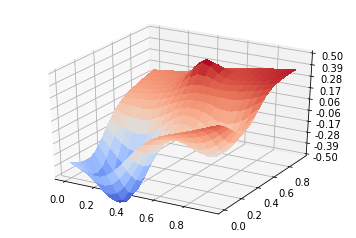

In [61]:
# retrain model as it has been modified by BV and variance computations
bestLasso.train(XY, z)

# Do a plot of the best model - franke
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make plot points .
xpoints = np.arange(0, 1, 0.05)
ypoints = np.arange(0, 1, 0.05)
xm, ym = np.meshgrid(xpoints,ypoints)

# Plot the real and predicted surfaces.
diffsurf = ax.plot_surface(xm, ym, np.vectorize(bestLasso.plotfunc)(xm,ym) - FrankeFunction(xm, ym), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.50, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(realsurf, shrink=0.5, aspect=5)

plt.show()

## Parts d and e

### Loading Tarain data (part d)

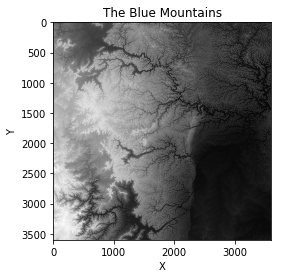

(3601, 3601)


In [67]:
################
# I got my tarrain data by searching for blue mountains on earthexplorer
# Used Blue Mountains, New South Wales, Australia -33.4100 150.3037
################

# Load the terrain
terrain1 = imread('s34_e150_1arc_v3.tif')
# Show the terrain
plt.figure()
plt.title('The Blue Mountains')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

terrain_array = np.array(terrain1) 
print(terrain_array.shape)

## Terrain analysis (part e) - model selection

In [68]:
def terrain_function(row) :
    return terrain_array[(row[0], row[1])]

# Setup input data. 
# We pick a 1000 (x,y) integer points at random
# the z's according to the fomula and with some noise
tnumberofpoints = 10000
tnoise = 0.5
tXY = np.random.randint(3600, size = (tnumberofpoints, 2))

tz = np.apply_along_axis(terrain_function, 1, tXY).reshape(-1,1)

# Now we make some "clean" data 
# Models will never be trained on this, only tested against it 
ctXY = np.random.randint(3600, size = (1000, 2))
ctz = np.apply_along_axis(terrain_function, 1, ctXY).reshape(-1,1)

print("we do cross fold validation to pick the best model")
cv_list = []
#first we try the OLS models

for n in range(1,6) :
    pOLS = polynomialOLS(n)
    cv = cross_validation(10, tXY, tz, pRidge)
    cv_list.append((cv,("OLS", n)))

# then we try Ridge
for n in range(1,6) :
    for a in [0.1, 0.2, 0.5, 1] : 
        pRidge = polynomialRidge(n, a)
        cv = cross_validation(10, tXY, tz, pRidge)
        cv_list.append((cv,("Ridge", n, a)))

# then we try Ridge
for n in range(1,6) :
    for a in [0.1, 0.2, 0.5, 1] : 
        pLasso = polynomialLasso(n, a)
        cv = cross_validation(10, tXY, tz, pLasso)
        cv_list.append((cv,("Lasso", n, a)))
                   
cv_list.sort(key=lambda tup: tup[0]) #sort the list by the cv value

print(cv_list[0])

# Again the results are not exactly fixed, but when I ran it, I got 
# Ridge with degree 3 with lambda 0.2

we do cross fold validation to pick the best model
(27589.21792591468, ('Ridge', 3, 0.5))


### Working with chosen model

In [74]:
# We will work with a degree 3 polynomial and a lambda of 0.5
# We test the actual statistics against the unseen (clean) data
tmodel = polynomialRidge(3, 0.5)
tmodel.train(tXY, tz)
print("The coefficients for our best model is:")
print(tmodel.coefficients())
test_against_new(ctXY, ctz, tmodel)

# Now we compute the bias and variance of our model
# and esitamte the variance of the parameters beta

print("")
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, tXY, tz, tmodel)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("Using 10 folds to compute variances of betas")
print(beta_variance(10, tXY, tz, tmodel))

The coefficients for our best model is:
[[ 7.74423356e+02]
 [ 2.63623576e-01]
 [-2.41755778e-01]
 [-6.09620512e-05]
 [-4.45552817e-05]
 [ 1.35688615e-05]
 [ 6.49809862e-09]
 [ 1.08423133e-08]
 [ 4.29164295e-09]
 [ 1.75566896e-10]]
Ridge regression, trying to fit a polynomial of degree 3 
Lambda = 0.5000
MSE = 27383.656382
R2 scrore = 0.767798
----------------

Using 9 folds to predict variance and bias
The bias is 24636.566560
The variance is 5.116623

Using 10 folds to compute variances of betas
[1.42955179e+01 3.32090863e-06 1.19403923e-05 2.00656719e-13
 2.76789538e-13 5.22608739e-13 3.33498950e-19 8.82435959e-20
 2.44105857e-19 8.89518016e-20]


### ploting terrain

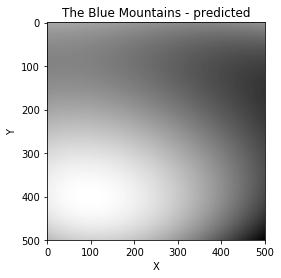

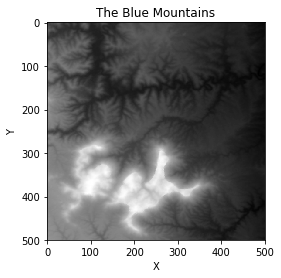

The coefficients for our best model is:
[[ 6.03684600e+02]
 [-2.08347169e+00]
 [-7.31907064e-03]
 [ 1.40890570e-02]
 [ 1.25217434e-03]
 [-1.45402890e-03]
 [-1.95642716e-05]
 [ 1.83078371e-06]
 [-7.47418512e-06]
 [ 2.55957023e-06]]
Ridge regression, trying to fit a polynomial of degree 3 
Lambda = 0.5000
MSE = 6684.622435
R2 scrore = 0.713436
----------------


In [76]:
# Because of limited computing power of my laptop, 
# we will restrict our selves to the 500 by 500 top corner of the map
# We train our model on some data from there, 
# Then plot it and the real map

restricted_XY = np.random.randint(499, size = (10000, 2))
restricted_z = np.apply_along_axis(terrain_function, 1, restricted_XY).reshape(-1,1)

rc_XY = np.random.randint(499, size = (1000, 2))
rc_z = np.apply_along_axis(terrain_function, 1, rc_XY).reshape(-1,1)

tmodel = polynomialRidge(3, 0.5)
tmodel.train(restricted_XY, restricted_z)

# plot a patch of our predicted landscape
my_terrain = np.rint(np.vstack([np.hstack([ tmodel.plotfunc(tx,ty) for ty in range(500)]) for tx in range(500)])) 
plt.figure()
plt.title('The Blue Mountains - predicted')
plt.imshow(my_terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Show the terrain
plt.figure()
plt.title('The Blue Mountains')
plt.imshow(terrain_array[:500, :500], cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print("The coefficients for our best model is:")
print(tmodel.coefficients())
test_against_new(rc_XY, rc_z, tmodel)
